In [1]:
# -----------------------------------------------------------
# 0. ONE-TIME INSTALL  (comment these two lines out after the
#    first run – keeps the rest of the script compact)
# -----------------------------------------------------------
# !pip install -q --upgrade "transformers[tf]==4.40.1"  pillow scikit-learn

# -----------------------------------------------------------
# 1. IMPORTS  &  REPRODUCIBILITY
# -----------------------------------------------------------
import os, numpy as np, tensorflow as tf, cv2, matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import (
    TFViTModel, AutoConfig,
)
from transformers import TFDeiTModel

np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------------------------------------
# 2. DATA  PATHS  &  CONFIG
# -----------------------------------------------------------
IMG_SIZE     = 224        # keep both backbones happy
BATCH_SIZE   = 32
EPOCHS       = 30
DATASET_DIR  = "/kaggle/input/brain-tumor-mri-dataset/"
TRAIN_DIR    = os.path.join(DATASET_DIR, "Training")
TEST_DIR     = os.path.join(DATASET_DIR,  "Testing")
OUT_DIR      = "./results"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------------------------------------
# 3. DATA  GENERATORS   (simple 0-1 rescale)
# -----------------------------------------------------------
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1,
    horizontal_flip=True, vertical_flip=True
)
datagen_test  = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical", batch_size=BATCH_SIZE, shuffle=True
)
test_gen  = datagen_test.flow_from_directory(
    TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical", batch_size=BATCH_SIZE, shuffle=False
)

NUM_CLASSES = train_gen.num_classes
CLASS_NAMES = list(train_gen.class_indices.keys())

# -----------------------------------------------------------
# 4.  BACKBONE  WRAPPERS  (ViT-B/16 & DeIT-Tiny)
# -----------------------------------------------------------
def make_vit_b16(img_size=224):
    vit = TFViTModel.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        from_pt=True
    )
    vit.trainable = False

    inp = Input(shape=(img_size, img_size, 3), dtype=tf.float32)

    tokens = layers.Lambda(
        lambda x: vit(tf.transpose(x, [0, 3, 1, 2]), training=False).last_hidden_state
    )(inp)

    feat = layers.GlobalAveragePooling1D()(tokens)
    
    model = Model(inp, feat, name="ViT_B16")
    model.vit = vit  # <-- explicitly store TFViTModel here
    return model


def make_deit_tiny(img_size=224):
    deit = TFDeiTModel.from_pretrained(
        "facebook/deit-tiny-patch16-224",
        from_pt=True
    )
    deit.trainable = False
    inp = Input(shape=(img_size, img_size, 3), dtype=tf.float32)

    tokens = layers.Lambda(
        lambda x: deit(tf.transpose(x, [0, 3, 1, 2]), training=False).last_hidden_state
    )(inp)                              # (None, 197, 192)
    feat = layers.GlobalAveragePooling1D()(tokens)
    return Model(inp, feat, name="DeiT_Tiny")


# 5.   ENSEMBLE  HEAD
# -----------------------------------------------------------
def build_transformer_ensemble(num_classes, img_size=224):
    inp       = Input(shape=(img_size, img_size, 3), dtype=tf.float32)

    vit_feat  = make_vit_b16(img_size)(inp)
    deit_feat = make_deit_tiny(img_size)(inp)        

    merged    = layers.Concatenate()([vit_feat, deit_feat])
    x         = layers.Dense(512, activation="relu")(merged)
    x         = layers.Dropout(0.5)(x)
    out       = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inp, out, name="Ensemble_ViT_DeIT")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


model = build_transformer_ensemble(NUM_CLASSES, IMG_SIZE)
model.summary(line_length=130)

# -----------------------------------------------------------
# 6.  TRAIN
# -----------------------------------------------------------
callbacks = [
    EarlyStopping(monitor="loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="loss", factor=0.3, patience=3, min_lr=1e-6, verbose=1),
]
history = model.fit(
    train_gen, epochs=EPOCHS,
    callbacks=callbacks
)

# -----------------------------------------------------------
# 7.  EVALUATE
# -----------------------------------------------------------
test_gen.reset()
preds   = model.predict(test_gen, verbose=0)
y_pred  = np.argmax(preds, axis=1)
y_true  = test_gen.classes[:len(y_pred)]

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# -----------------------------------------------------------
# 8.  SIMPLE  GRAD-CAM  FOR  ViT  (patch-embeddings heat map)
#     – gives a coarse idea of attended regions.
# -----------------------------------------------------------
def vit_gradcam(img_path, model, out_path):
    # fetch ViT sub-model
    vit_branch  = model.get_layer("ViT_B16")
    vit_tfmodel = vit_branch.vit  # <-- access directly from stored attribute
    patch_layer = vit_tfmodel.vit.embeddings.patch_embeddings

    # 2) load & preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, 0)

    with tf.GradientTape() as tape:
        tape.watch(arr)
        tokens = vit_tfmodel(tf.transpose(arr, [0, 3, 1, 2]), training=False).last_hidden_state
        logits = model(arr, training=False)
        pred = tf.argmax(logits, axis=-1)
        loss = logits[:, pred[0]]

    grads = tape.gradient(loss, tokens)
    weights = tf.reduce_mean(grads, axis=1, keepdims=True)
    cam = tf.reduce_sum(tf.multiply(weights, tokens), axis=-1)
    cam = tf.reshape(cam[:, 1:], (14, 14))  # exclude CLS token, reshape for 14x14 patches
    cam = tf.nn.relu(cam)
    cam = cam / tf.reduce_max(cam)

    # convert to heatmap
    heatmap = cam.numpy()
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # overlay
    original = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)
    cv2.imwrite(out_path, overlay)
    print(f"Grad-CAM saved → {out_path}")


# Example on the first test image
example_img = test_gen.filepaths[0]
vit_gradcam(example_img, model, os.path.join(OUT_DIR, "gradcam_vit.jpg"))

2025-04-25 17:00:11.706523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745600411.990622      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745600412.055527      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

I0000 00:00:1745600436.973827      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1745600437.897826      31 cuda_dnn.cc:529] Loaded cuDNN version 90300
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

You are using a model of type vit to instantiate a model of type deit. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDeiTModel: ['vit.encoder.layer.5.intermediate.dense.bias', 'vit.encoder.layer.2.attention.attention.key.bias', 'vit.encoder.layer.2.attention.output.dense.weight', 'vit.encoder.layer.2.layernorm_before.bias', 'vit.encoder.layer.4.attention.output.dense.bias', 'vit.encoder.layer.3.attention.attention.key.weight', 'vit.encoder.layer.7.layernorm_before.bias', 'vit.encoder.layer.9.attention.attention.value.bias', 'vit.encoder.layer.4.layernorm_after.bias', 'vit.encoder.layer.3.output.dense.weight', 'vit.layernorm.weight', 'vit.encoder.layer.5.layernorm_before.weight', 'vit.encoder.layer.0.output.dense.weight', 'vit.encoder.layer.7.attention.output.dense.weight', 'vit.encoder.layer.2.output.dense.weight', 'vit.encoder.layer.5.attention.attention.query.bias', 'vit.encoder.layer.1.layernorm_before.bias', 'vit.encoder.layer.11.output.dense.weight', 'vit.encoder.layer.9.layernorm_before.weight', 'vit.encoder.la

Model: "Ensemble_ViT_Swin"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                         ┃ Output Shape                   ┃              Param # ┃ Connected to      
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)             │ (None, 224, 224, 3)            │                    0 │ -                 
├──────────────────────────────────────┼────────────────────────────────┼──────────────────────┼───────────────────
│ ViT_B16 (Functional)                 │ (None, 768)                    │                    0 │ input_layer[0][0] 
├──────────────────────────────────────┼────────────────────────────────┼──────────────────────┼───────────────────
│ DeiT_Tiny (Functional)               │ (None, 192)                    │                    0 │ input_layer[0][0] 
├──────────────────────────────────────┼────────────────────────────────┼──────────────────────┼───────────────────
│ concatenate (Concatenate)            │ (None, 960)                    │                    0 │ ViT_B16[0][0], Dei
├──────────────────────────────────────┼────────────────────────────────┼──────────────────────┼───────────────────
│ dense (Dense)                        │ (None, 512)                    │              492,032 │ concatenate[0][0] 
├──────────────────────────────────────┼────────────────────────────────┼──────────────────────┼───────────────────
│ dropout (Dropout)                    │ (None, 512)                    │                    0 │ dense[0][0]       
├──────────────────────────────────────┼────────────────────────────────┼──────────────────────┼───────────────────
│ dense_1 (Dense)                      │ (None, 4)                      │                2,052 │ dropout[0][0]     
└──────────────────────────────────────┴────────────────────────────────┴──────────────────────┴───────────────────

 Total params: 494,084 (1.88 MB)

 Trainable params: 494,084 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745600486.598535     105 service.cc:148] XLA service 0x7a3818003b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745600486.599428     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745600495.060723     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 126s 463ms/step - accuracy: 0.4764 - loss: 1.1688 - learning_rate: 1.0000e-04
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 347ms/step - accuracy: 0.7614 - loss: 0.6810 - learning_rate: 1.0000e-04
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 343ms/step - accuracy: 0.8006 - loss: 0.5613 - learning_rate: 1.0000e-04
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 63s 340ms/step - accuracy: 0.8226 - loss: 0.4848 - learning_rate: 1.0000e-04
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 344ms/step - accuracy: 0.8374 - loss: 0.4546 - learning_rate: 1.0000e-04
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 345ms/step - accuracy: 0.8460 - loss: 0.4241 - learning_rate: 1.0000e-04
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 346ms/step - accuracy: 0.8655 - loss: 0.3862 - learning_rate: 1.0000e-04
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 350ms/step - accuracy: 0.8695 - loss: 0.3708 - learning_rate: 1.0000e-04
Epoch 9/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 346ms/step - accuracy: 0.8745 

ValueError: Passed in object [[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]] of type 'ndarray', not tf.Tensor or tf.Variable or ExtensionType.

In [44]:


# 2) imports (note the reshape import)
import torch, timm, cv2, numpy as np
from PIL import Image
from torchvision import transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
# ← use the ViT-specific reshape transform
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform as reshape_transform

# 3) device & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = timm.create_model("vit_base_patch16_224", pretrained=True).to(device).eval()

# 4) pick a layer *before* the final attention block
target_layers = [model.blocks[-1].norm1]

# 5) init GradCAM (no use_cuda arg!)
cam = GradCAM(
    model=model,
    target_layers=target_layers,
    reshape_transform=reshape_transform,
)

# 6) preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])

def get_vit_cam(input_path, output_path, class_idx=None):
    # --- 1) Prepare model input via torchvision (resizes to 224×224) ---
    pil_img     = Image.open(input_path).convert("RGB")
    input_tensor= preprocess(pil_img).unsqueeze(0).to(device)  # B×3×224×224

    # --- 2) Read & resize for overlay (224×224) ---
    orig_bgr    = cv2.imread(input_path)
    orig_bgr    = cv2.resize(orig_bgr, (224, 224))
    rgb         = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB) / 255.0  # float32 [224,224,3]

    # --- 3) Run Grad-CAM ---
    targets     = [ClassifierOutputTarget(class_idx)] if class_idx is not None else None
    mask        = cam(input_tensor=input_tensor, targets=targets)[0]  # [224,224]

    # --- 4) Overlay & save ---
    cam_image   = show_cam_on_image(rgb, mask, use_rgb=True)         # [224,224,3]
    cv2.imwrite(output_path, cam_image[:, :, ::-1])    
# Example
get_vit_cam(test_gen.filepaths[0], "vit_gradcam_out.jpg")


# Testing on new dataset almost 3000 images

Found 3160 images belonging to 4 classes.
 1/99 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step
Combined Dataset Accuracy: 0.8591772151898734


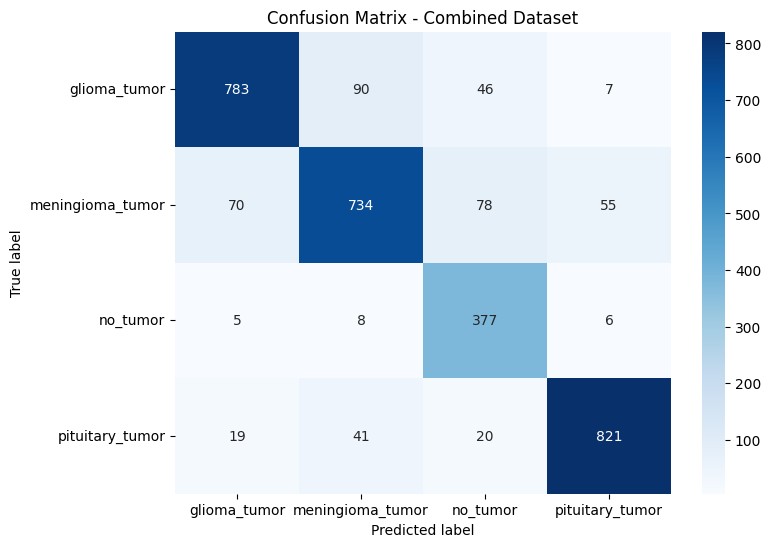

                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.85      0.87       926
meningioma_tumor       0.84      0.78      0.81       937
        no_tumor       0.72      0.95      0.82       396
 pituitary_tumor       0.92      0.91      0.92       901

        accuracy                           0.86      3160
       macro avg       0.85      0.87      0.85      3160
    weighted avg       0.86      0.86      0.86      3160



In [7]:
import os, shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
ORIG_DIR = "/kaggle/input/brain-tumor-classification-mri"
COMBINED_DIR = "./combined_dataset"

# Combine Training and Testing correctly
if not os.path.exists(COMBINED_DIR):
    os.makedirs(COMBINED_DIR)
    for split in ['Training', 'Testing']:
        split_dir = os.path.join(ORIG_DIR, split)
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            target_dir = os.path.join(COMBINED_DIR, class_name)
            os.makedirs(target_dir, exist_ok=True)
            for fname in os.listdir(class_dir):
                shutil.copy2(os.path.join(class_dir, fname), target_dir)

# Data generator
combined_datagen = ImageDataGenerator(rescale=1./255)
combined_gen = combined_datagen.flow_from_directory(
    COMBINED_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predictions
combined_preds = model.predict(combined_gen, verbose=1)
y_pred_combined = np.argmax(combined_preds, axis=1)
y_true_combined = combined_gen.classes
class_labels = list(combined_gen.class_indices.keys())

# Accuracy
print("Combined Dataset Accuracy:", accuracy_score(y_true_combined, y_pred_combined))

# Confusion Matrix
cm = confusion_matrix(y_true_combined, y_pred_combined)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix - Combined Dataset')
plt.show()

# Classification report
report = classification_report(y_true_combined, y_pred_combined, target_names=class_labels)
print(report)
